# Self-Consistency Sampling

Self-consistency sampling is an advanced prompt engineering technique that enhances the reasoning capabilities of LLMs. This method builds upon chain-of-thought prompting by introducing diversity and consistency checks into the reasoning process. Instead of relying on a single output, self-consistency sampling generates multiple reasoning paths for a given problem. It does this by using temperature sampling or other decoding strategies to produce a variety of potential solutions. The key insight is that while individual reasoning attempts may contain errors, the correct answer is likely to appear consistently across multiple attempts. After generating these diverse paths, the technique aggregates the results, typically by selecting the most frequent answer. 

This approach leverages the model's ability to approach problems from different angles, potentially overcoming biases or errors present in any single reasoning attempt. Self-consistency sampling is particularly effective for complex reasoning tasks, such as mathematical problem-solving or multi-step logical deductions, where it can significantly improve accuracy without requiring any additional training of the underlying model. By embracing variability in the model's outputs, this technique offers a robust way to enhance the reliability and performance of language models in reasoning tasks.

### Self-Consistency Improves Chain of Thought Reasoning in Language Models

This paper introduces a novel decoding strategy called "self-consistency" to improve chain-of-thought reasoning in large language models. The method works by first prompting the model with chain-of-thought exemplars, then sampling multiple diverse reasoning paths from the model's decoder instead of greedily decoding a single path. Finally, it marginalizes out the reasoning paths to find the most consistent answer among the sampled outputs. 

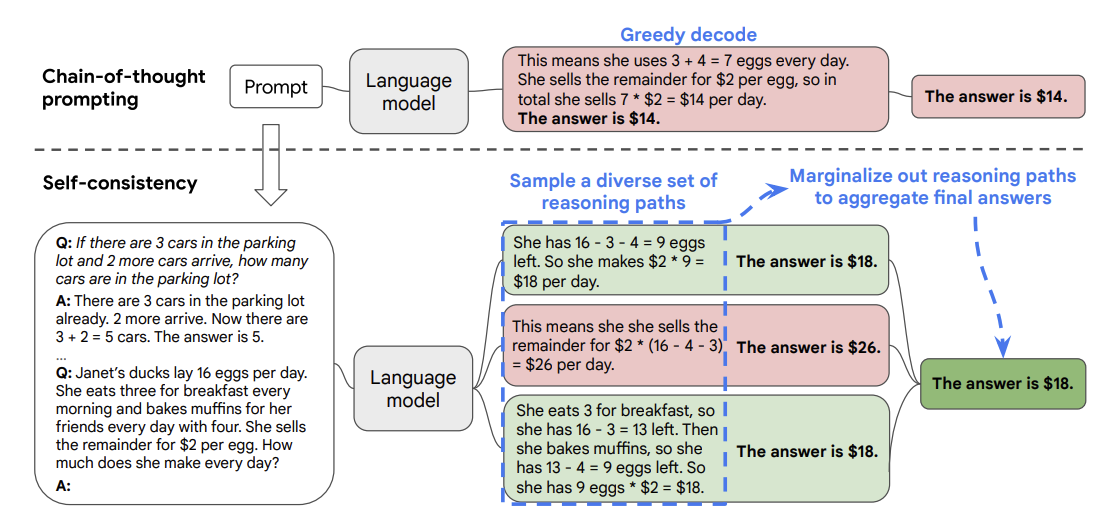

This approach leverages the intuition that complex reasoning tasks often have multiple valid paths to the correct answer, and correct reasoning tends to converge on consistent conclusions. The authors demonstrate that self-consistency significantly improves performance across a range of arithmetic and commonsense reasoning tasks, outperforming existing methods like sample-and-rank, beam search, and ensemble approaches. They show substantial gains on benchmarks such as GSM8K (+17.9%), SVAMP (+11.0%), AQuA (+12.2%), StrategyQA (+6.4%), and ARC-challenge (+3.9%). Importantly, self-consistency requires no additional training or fine-tuning and works with off-the-shelf language models, making it a simple yet effective method for enhancing reasoning capabilities in large language models.

> [Self-Consistency Improves Chain of Thought Reasoning in Language Models](https://arxiv.org/abs/2203.11171) by Wang et al., (2023)


In [2]:
import asyncio
from openai import AsyncOpenAI
import nest_asyncio
from collections import Counter
import json


# Initialize the AsyncOpenAI client
client = AsyncOpenAI()

nest_asyncio.apply() # to run in a jupyter notebook async

async def generate_reasoning_path(question, temperature=0.7):
    """Generates a reasoning path using the OpenAI API asynchronously."""
    response = await client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": """You are a helpful assistant that provides step-by-step reasoning for questions. Provide a step-by-step reasoning and final answer as keys in JSON step_by_step_reasoning, and final_answer."""},
            {"role": "user", "content": f"{question}"}
        ],
        temperature=temperature,
        max_tokens=1000
    )
    return response.choices[0].message.content

def extract_answer(reasoning_path):
    """Extracts the final answer from a reasoning path."""
    try:
        parsed_json = json.loads(reasoning_path)
        return parsed_json.get('final_answer', '').replace('$', '')
    except json.JSONDecodeError:
        return ""

async def self_consistency(question, num_samples=5):
    """Implements the self-consistency method using the OpenAI API asynchronously."""
    tasks = [generate_reasoning_path(question) for _ in range(num_samples)]
    sampled_paths = await asyncio.gather(*tasks)
    answers = [extract_answer(path) for path in sampled_paths]
    most_common_answer = Counter(answers).most_common(1)[0][0]
    return most_common_answer, answers, sampled_paths

# Example usage
async def main():
    question = """Q: If there are 3 cars in the parking
    lot and 2 more cars arrive, how many
    cars are in the parking lot?
    A: {"step_by_step_reasoning": "There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.", "final_answer": "5"}

    Q: A factory produces widgets and gadgets. Each widget requires 3 units of material A and 2 units of material B. Each gadget requires 2 units of material A and 4 units of material B. The factory has 180 units of material A and 160 units of material B available. If the profit on each widget is $12 and on each gadget is $15, what is the maximum profit the factory can make?
    A:"""
    final_answer, answers, reasoning_paths = await self_consistency(question, num_samples=5)

    print(f"The most consistent answer is: {final_answer}")
    print("List of answers:")
    for i, answer in enumerate(answers, 1):
        print(f"Answer {i}: {answer}")
    print("\nReasoning paths:")
    for i, path in enumerate(reasoning_paths, 1):
        print(f"\nPath {i}:")
        print(path)

# Run the async main function
asyncio.run(main())

The most consistent answer is: 825
List of answers:
Answer 1: 825
Answer 2: 
Answer 3: 
Answer 4: 825
Answer 5: The maximum profit the factory can make is 930.

Reasoning paths:

Path 1:
{
  "step_by_step_reasoning": [
    "Let x be the number of widgets produced and y be the number of gadgets produced.",
    "Each widget requires 3 units of material A and each gadget requires 2 units of material A. The total material A used is 3x + 2y.",
    "Each widget requires 2 units of material B and each gadget requires 4 units of material B. The total material B used is 2x + 4y.",
    "The constraints are: 3x + 2y <= 180 (material A constraint) and 2x + 4y <= 160 (material B constraint).",
    "The profit function to maximize is: P = 12x + 15y.",
    "First, simplify the constraints: 3x + 2y <= 180 and 2x + 4y <= 160.",
    "Divide the second constraint by 2: x + 2y <= 80.",
    "Now we have two constraints: 3x + 2y <= 180 and x + 2y <= 80.",
    "To find the feasible region, solve these inequa